In [17]:
import kagglehub
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingRegressor, VotingRegressor
from sklearn.svm import SVR
from sklearn.model_selection import cross_val_score, TimeSeriesSplit
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor

%matplotlib inline

### 1. Setup 

In [18]:
path = kagglehub.dataset_download("alejopaullier/new-york-city-weather-data-2019")
path = path + "/nyc_temperature.csv"

In [19]:
df = pd.read_csv(path) # reading the csv file
print(df.head())
df.columns

     date  tmax  tmin  tavg  departure  HDD  CDD precipitation new_snow  \
0  1/1/19    60    40  50.0       13.9   15    0          0.08        0   
1  2/1/19    41    35  38.0        2.1   27    0             0        0   
2  3/1/19    45    39  42.0        6.3   23    0             T        0   
3  4/1/19    47    37  42.0        6.5   23    0             0        0   
4  5/1/19    47    42  44.5        9.1   20    0          0.45        0   

  snow_depth  
0          0  
1          0  
2          0  
3          0  
4          0  


Index(['date', 'tmax', 'tmin', 'tavg', 'departure', 'HDD', 'CDD',
       'precipitation', 'new_snow', 'snow_depth'],
      dtype='object')

### 2. Basic Exploratory Data Analysis (EDA)

In [20]:
print("=== DataFrame Info ===")
df.info()

print("\n=== Missing Values ===")
print(df.isnull().sum())

print("\n=== Descriptive Statistics ===")
display(df.describe(include="all"))

=== DataFrame Info ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 365 entries, 0 to 364
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           365 non-null    object 
 1   tmax           365 non-null    int64  
 2   tmin           365 non-null    int64  
 3   tavg           365 non-null    float64
 4   departure      365 non-null    float64
 5   HDD            365 non-null    int64  
 6   CDD            365 non-null    int64  
 7   precipitation  365 non-null    object 
 8   new_snow       365 non-null    object 
 9   snow_depth     365 non-null    object 
dtypes: float64(2), int64(4), object(4)
memory usage: 28.6+ KB

=== Missing Values ===
date             0
tmax             0
tmin             0
tavg             0
departure        0
HDD              0
CDD              0
precipitation    0
new_snow         0
snow_depth       0
dtype: int64

=== Descriptive Statistics ===


,date,tmax,tmin,tavg,departure,HDD,CDD,precipitation,new_snow,snow_depth
count,365,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365,365,365
unique,365,NaN,NaN,NaN,NaN,NaN,NaN,71,14,6
top,1/1/19,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0
freq,1,NaN,NaN,NaN,NaN,NaN,NaN,176,337,349
mean,NaN,63.169863,49.512329,56.341096,-0.527945,12.463014,4.065753,NaN,NaN,NaN
std,NaN,18.806232,17.154853,17.821404,6.421460,13.264920,6.374835,NaN,NaN,NaN
min,NaN,16.000000,3.000000,10.000000,-24.100000,0.000000,0.000000,NaN,NaN,NaN
25%,NaN,47.000000,35.000000,41.000000,-4.700000,0.000000,0.000000,NaN,NaN,NaN
50%,NaN,63.000000,49.000000,56.000000,0.100000,9.000000,0.000000,NaN,NaN,NaN
75%,NaN,79.000000,65.000000,72.000000,3.700000,24.000000,7.000000,NaN,NaN,NaN


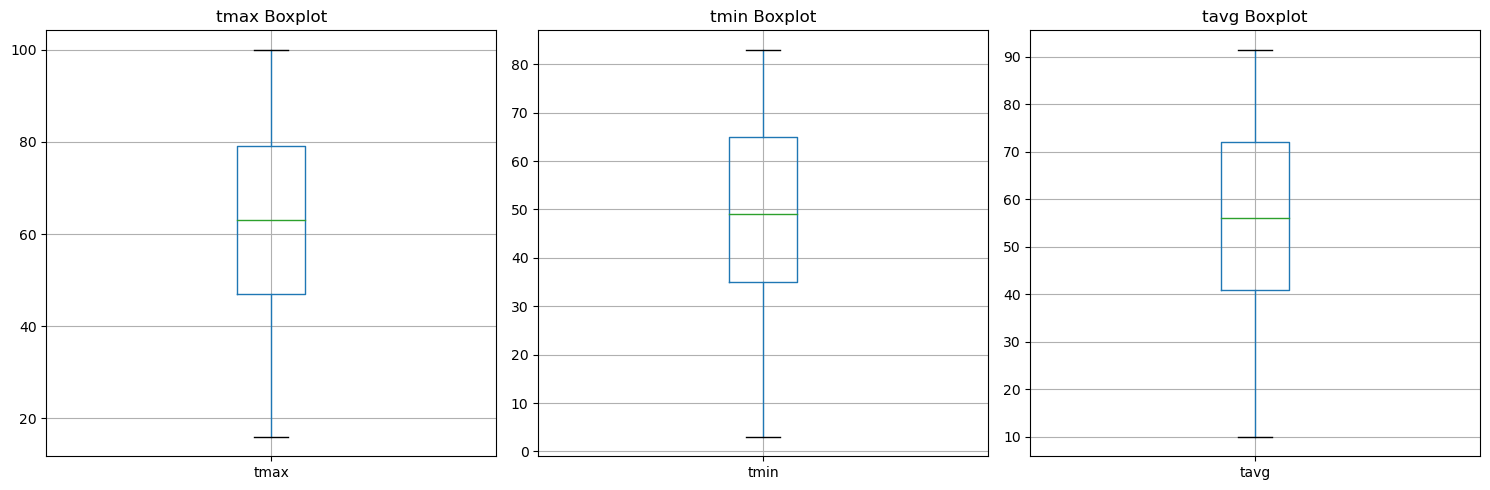

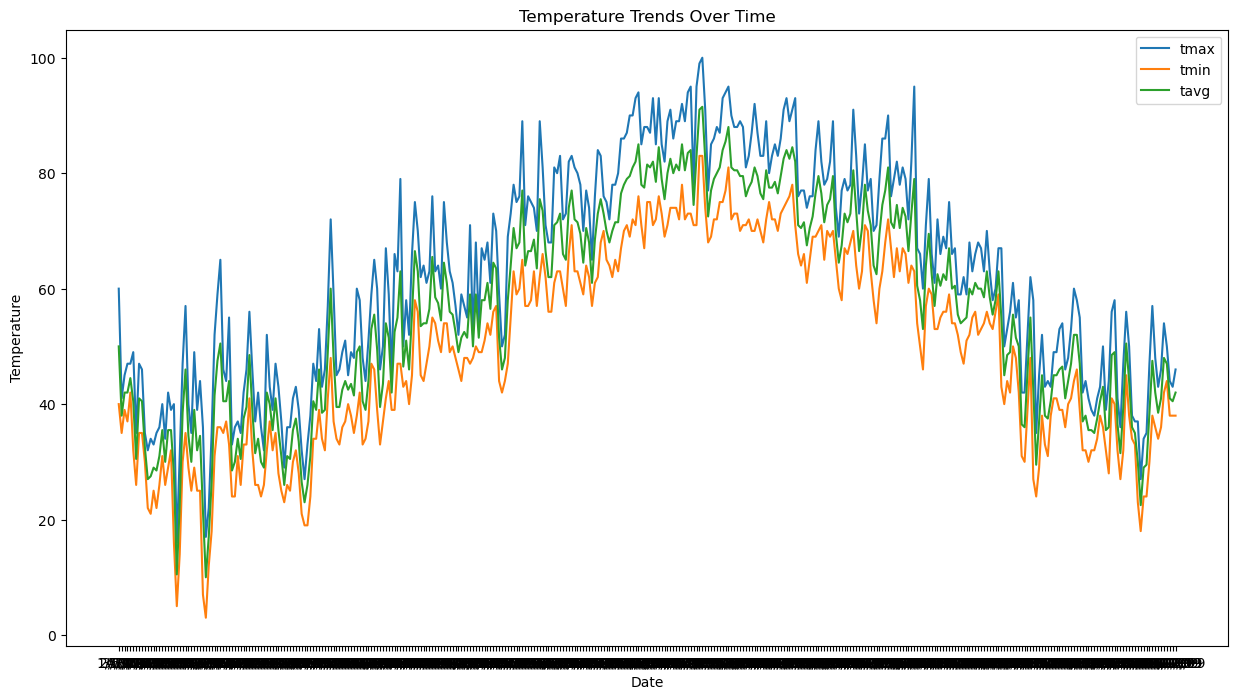

In [21]:
### 2.1 Data Quality Checks
def plot_boxplots(df, columns):
    plt.figure(figsize=(15, 5))
    for i, col in enumerate(columns, 1):
        plt.subplot(1, len(columns), i)
        df.boxplot(column=col)
        plt.title(f"{col} Boxplot")
    plt.tight_layout()
    plt.show()


# Plot outliers for main temperature columns
plot_boxplots(df, ["tmax", "tmin", "tavg"])


### 2.2 Time Series Analysis
def plot_time_series(df, columns):
    plt.figure(figsize=(15, 8))
    for col in columns:
        plt.plot(df["date"], df[col], label=col)
    plt.title("Temperature Trends Over Time")
    plt.xlabel("Date")
    plt.ylabel("Temperature")
    plt.legend()
    plt.show()


plot_time_series(df, ["tmax", "tmin", "tavg"])

### 3. Clean & Convert Columns

In [22]:
df["date"] = pd.to_datetime(df["date"]) # converting the date column to datetime

for col in ["precipitation", "new_snow", "snow_depth"]:
    df[col] = df[col].replace("T", "0.0")  # replacing the T with 0.0
    df[col] = df[col].astype(float)  # converting the column to float

print(df.dtypes)
df.head()

date             datetime64[ns]
tmax                      int64
tmin                      int64
tavg                    float64
departure               float64
HDD                       int64
CDD                       int64
precipitation           float64
new_snow                float64
snow_depth              float64
dtype: object


,date,tmax,tmin,tavg,departure,HDD,CDD,precipitation,new_snow,snow_depth
0,2019-01-01,60,40,50.0,13.9,15,0,0.08,0.0,0.0
1,2019-02-01,41,35,38.0,2.1,27,0,0.00,0.0,0.0
2,2019-03-01,45,39,42.0,6.3,23,0,0.00,0.0,0.0
3,2019-04-01,47,37,42.0,6.5,23,0,0.00,0.0,0.0
4,2019-05-01,47,42,44.5,9.1,20,0,0.45,0.0,0.0


## 4. Visualization

### 4.1 Correlation Heatmap


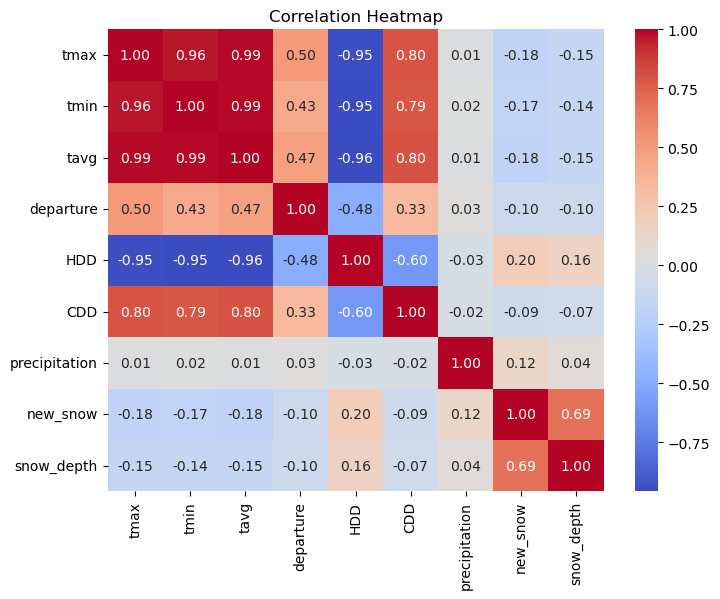

In [23]:
# A correlation plot for all numeric columns
numeric_cols = df.select_dtypes(include=[np.number]).columns
corr_matrix = df[numeric_cols].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()

### 4.2 Distribution Plots for Key Weather Columns


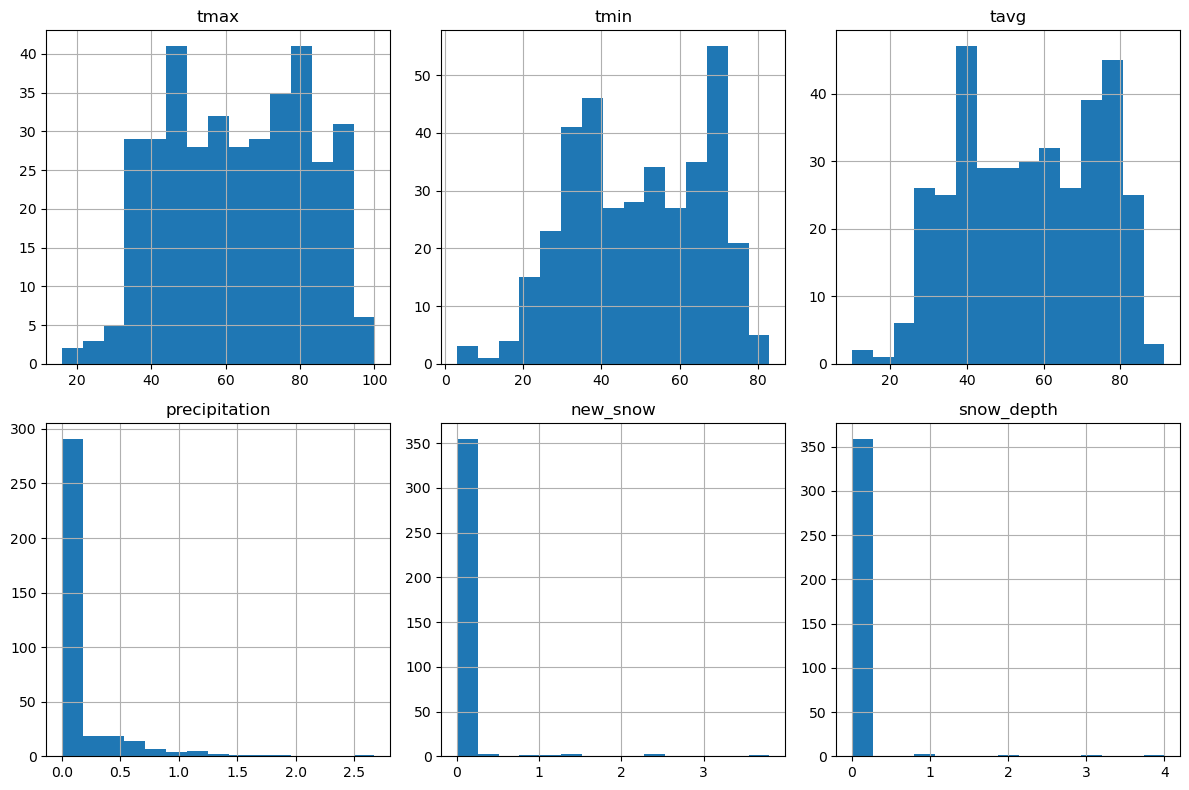

In [24]:
features_to_plot = ["tmax", "tmin", "tavg", "precipitation", "new_snow", "snow_depth"]
df[features_to_plot].hist(bins=15, figsize=(12, 8), layout=(2, 3))
plt.tight_layout()
plt.show()

## 5. Feature Engineering

In [25]:
# (Already done if you followed previous steps, but to confirm)
# Convert 'date' to datetime
df["date"] = pd.to_datetime(df["date"], errors="coerce")

# We'll create month, dayofyear, dayofweek from 'date'
df["month"] = df["date"].dt.month
df["dayofyear"] = df["date"].dt.dayofyear
df["dayofweek"] = df["date"].dt.dayofweek

# If you want to create "lag of tavg from yesterday" (2 days before, etc.), do:
df["tavg_lag1"] = df["tavg"].shift(1)
df["precip_lag1"] = df["precipitation"].shift(1)
df["tmax_lag1"] = df["tmax"].shift(1)
df["tmin_lag1"] = df["tmin"].shift(1)

df["temp_range"] = df["tmax"] - df["tmin"]
df["rolling_mean_temp"] = df["tavg"].rolling(window=7).mean()
df["rolling_std_temp"] = df["tavg"].rolling(window=7).std()

# Create seasonal features using cyclic encoding
df["month_sin"] = np.sin(2 * np.pi * df["month"] / 12)
df["month_cos"] = np.cos(2 * np.pi * df["month"] / 12)

# Drop rows where lag features are NaN (the first row, etc.)
df = df.dropna(
    subset=["tavg_lag1", "precip_lag1", "tmax_lag1", "tmin_lag1"]
).reset_index(drop=True)

df.head()
df.columns

Index(['date', 'tmax', 'tmin', 'tavg', 'departure', 'HDD', 'CDD',
       'precipitation', 'new_snow', 'snow_depth', 'month', 'dayofyear',
       'dayofweek', 'tavg_lag1', 'precip_lag1', 'tmax_lag1', 'tmin_lag1',
       'temp_range', 'rolling_mean_temp', 'rolling_std_temp', 'month_sin',
       'month_cos'],
      dtype='object')

### 6. Model Building

In [26]:
df["tavg_next_day"] = df["tavg"].shift(-1)
target = "tavg_next_day"

# Choose features from "today"
features = [
    "month_sin",
    "month_cos",
    "tavg",
    "tmax",
    "tmin",
    "temp_range",
    "rolling_mean_temp",
    "rolling_std_temp",
    "departure",
    "HDD",
    "CDD",
    "tavg_lag1",
    "tmax_lag1",
    "tmin_lag1",
]

### 5.1 Advanced Feature Engineering
# Temperature volatility
df["temp_volatility"] = (
    df["tavg"].rolling(window=7).std() / df["tavg"].rolling(window=7).mean()
)

# Create interaction features
df["temp_hdd_interaction"] = df["tavg"] * df["HDD"]
df["temp_cdd_interaction"] = df["tavg"] * df["CDD"]

# Create polynomial features for temperature
df["tavg_squared"] = df["tavg"] ** 2

# Create seasonal indicators
df["is_summer"] = (df["month"].isin([6, 7, 8])).astype(int)
df["is_winter"] = (df["month"].isin([12, 1, 2])).astype(int)

# Update features list to include new features
features.extend(
    [
        "temp_volatility",
        "temp_hdd_interaction",
        "temp_cdd_interaction",
        "tavg_squared",
        "is_summer",
        "is_winter",
    ]
)

df_model = df.dropna(subset=features + [target])

# Prepare data
X = df_model[features].copy()
y = df_model[target].copy()

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

# Use TimeSeriesSplit instead of regular train_test_split
tscv = TimeSeriesSplit(n_splits=5)
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, shuffle=False
)

In [27]:
from sklearn.ensemble import RandomForestRegressor


models = {
    "xgb": XGBRegressor(
        n_estimators=200, learning_rate=0.1, max_depth=5, random_state=42
    ),
    "gbm": GradientBoostingRegressor(
        n_estimators=200, learning_rate=0.1, max_depth=5, random_state=42
    ),
    "rf": RandomForestRegressor(n_estimators=200, max_depth=10, random_state=42),
}

In [28]:
from sklearn.model_selection import RandomizedSearchCV

# Example for XGBoost hyperparameter tuning
param_dist = {
    "n_estimators": [100, 200, 300],
    "max_depth": [3, 4, 5, 6],
    "learning_rate": [0.01, 0.1, 0.3],
    "subsample": [0.8, 0.9, 1.0],
}

xgb_tuned = RandomizedSearchCV(
    XGBRegressor(random_state=42),
    param_distributions=param_dist,
    n_iter=10,
    cv=tscv,
    scoring="neg_root_mean_squared_error",
    random_state=42,
)

xgb_tuned.fit(X_train, y_train)
print("Best parameters:", xgb_tuned.best_params_)

Best parameters: {'subsample': 1.0, 'n_estimators': 200, 'max_depth': 3, 'learning_rate': 0.3}


In [29]:
# Train and evaluate models using cross-validation
for name, model in models.items():
    scores = cross_val_score(
        model, X_train, y_train, cv=tscv, scoring="neg_root_mean_squared_error"
    )
    print(f"{name} CV RMSE: {-scores.mean():.3f} (+/- {scores.std() * 2:.3f})")

# Create voting ensemble
voting_regressor = VotingRegressor(
    estimators=[(name, model) for name, model in models.items()]
)
voting_regressor.fit(X_train, y_train)

xgb CV RMSE: 10.783 (+/- 9.049)
gbm CV RMSE: 9.971 (+/- 8.805)
rf CV RMSE: 9.190 (+/- 7.328)


VotingRegressor(estimators=[('xgb',
                             XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, device=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          gamma=None, grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate...
                                          max_delta_step=None, max_depth=5,
                                          max_leaves=None,
                                          min_child_weight=None, missing=nan,
                                          monotone_constraints=None,
                                          multi_strategy=None, n_estimators=200,
                                          n_jobs=None, num_parallel_tree=None,
                                          random_state=42, ...)),
                            ('gbm',
                             GradientBoostingRegressor(max_depth=5,
                                                       n_estimators=200,
                                                       random_state=42)),
                            ('rf',
                             RandomForestRegressor(max_depth=10,
                                                   n_estimators=200,
                                                   random_state=42))])

In [30]:
# Final evaluation
y_pred = voting_regressor.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"\nEnsemble Model - Test RMSE: {rmse:.3f}")
print(f"Ensemble Model - Test R2: {r2:.3f}")


Ensemble Model - Test RMSE: 5.694
Ensemble Model - Test R2: 0.617


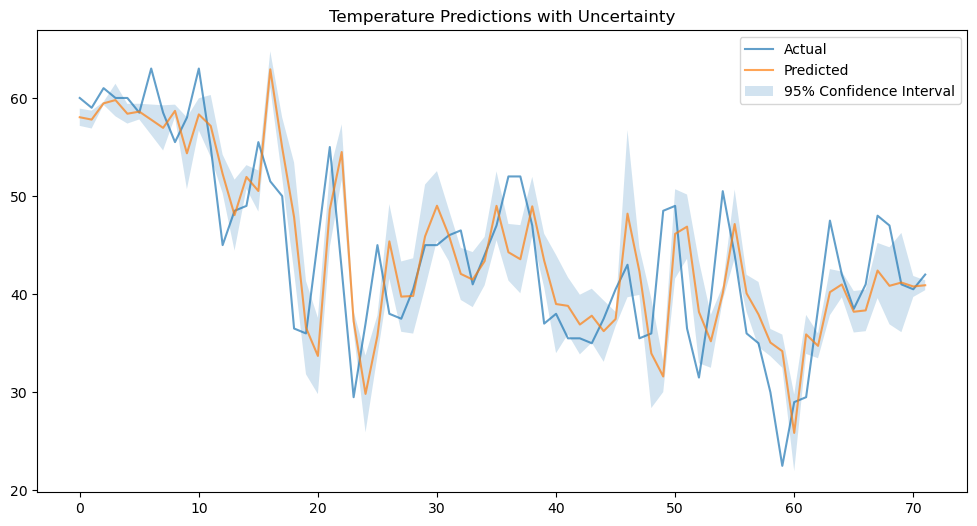

In [31]:
# Calculate prediction intervals
predictions = []
for model in models.values():
    model.fit(X_train, y_train)
    predictions.append(model.predict(X_test))

predictions = np.array(predictions)
mean_prediction = predictions.mean(axis=0)
std_prediction = predictions.std(axis=0)

# Plot predictions with uncertainty
plt.figure(figsize=(12, 6))
plt.plot(y_test.values, label="Actual", alpha=0.7)
plt.plot(mean_prediction, label="Predicted", alpha=0.7)
plt.fill_between(
    range(len(mean_prediction)),
    mean_prediction - 2 * std_prediction,
    mean_prediction + 2 * std_prediction,
    alpha=0.2,
    label="95% Confidence Interval",
)
plt.title("Temperature Predictions with Uncertainty")
plt.legend()
plt.show()

In [32]:
# Feature importance (using XGBoost as reference)
xgb = models["xgb"]
xgb.fit(X_train, y_train)
importance_df = pd.DataFrame(
    {"feature": features, "importance": xgb.feature_importances_}
)
importance_df = importance_df.sort_values("importance", ascending=False)
print("\nTop 5 Most Important Features:")
print(importance_df.head())


Top 5 Most Important Features:
                 feature  importance
4                   tmin    0.807552
2                   tavg    0.062233
6      rolling_mean_temp    0.052644
3                   tmax    0.026559
15  temp_hdd_interaction    0.008865


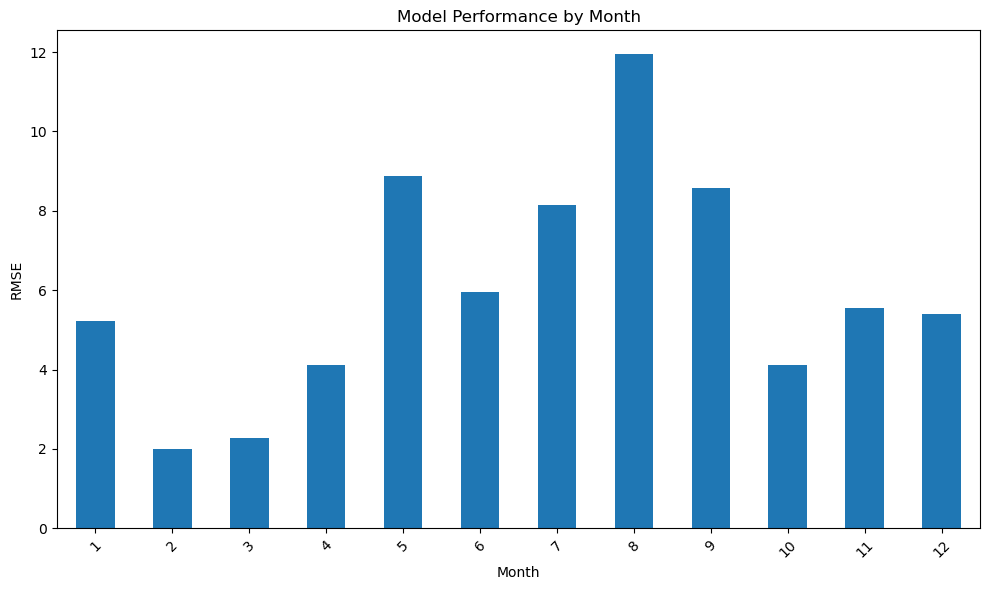

In [33]:
# Create seasonal performance analysis
test_df = pd.DataFrame(
    {
        "actual": y_test,
        "predicted": y_pred,
        "date": df.loc[y_test.index, "date"],
        "month": df.loc[y_test.index, "month"],
    }
)

seasonal_rmse = (
    test_df.groupby("month")
    .apply(lambda x: np.sqrt(mean_squared_error(x["actual"], x["predicted"])))
    .round(2)
)

plt.figure(figsize=(10, 6))
seasonal_rmse.plot(kind="bar")
plt.title("Model Performance by Month")
plt.xlabel("Month")
plt.ylabel("RMSE")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

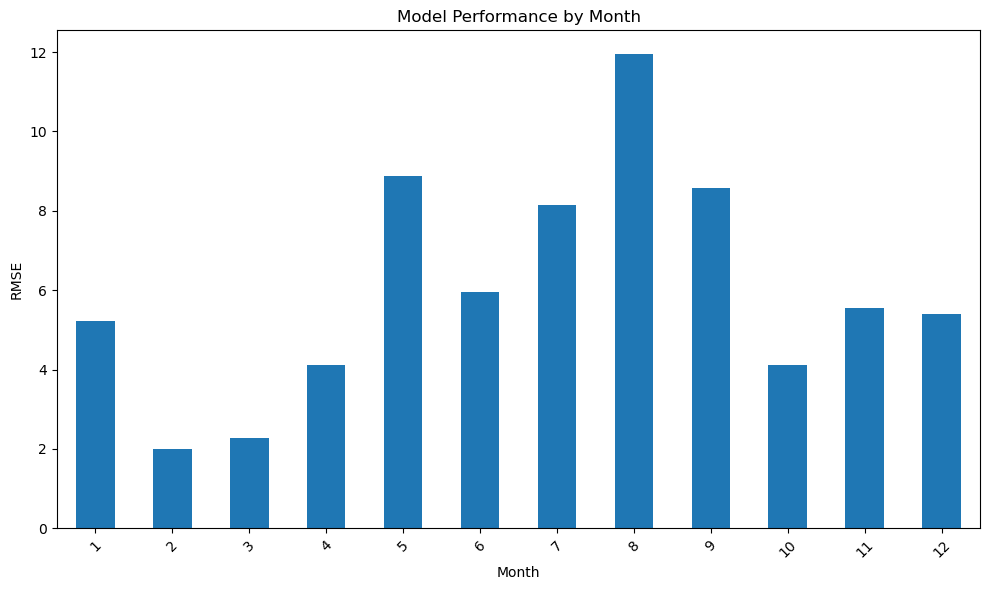

In [34]:
# Create seasonal performance analysis
test_df = pd.DataFrame(
    {
        "actual": y_test,
        "predicted": y_pred,
        "date": df.loc[y_test.index, "date"],
        "month": df.loc[y_test.index, "month"],
    }
)

seasonal_rmse = (
    test_df.groupby("month")
    .apply(lambda x: np.sqrt(mean_squared_error(x["actual"], x["predicted"])))
    .round(2)
)

plt.figure(figsize=(10, 6))
seasonal_rmse.plot(kind="bar")
plt.title("Model Performance by Month")
plt.xlabel("Month")
plt.ylabel("RMSE")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

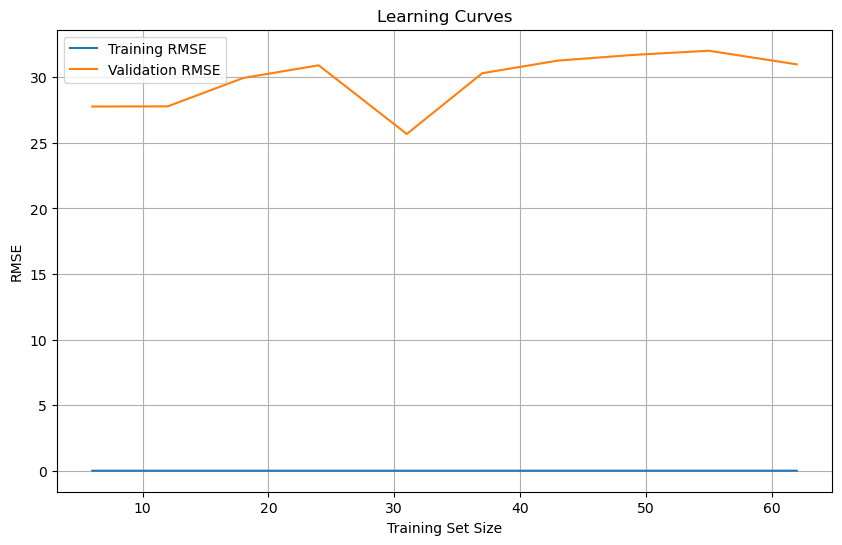

In [35]:
# Add learning curves analysis
from sklearn.model_selection import learning_curve


def plot_learning_curves(estimator, X, y):
    train_sizes, train_scores, test_scores = learning_curve(
        estimator,
        X,
        y,
        cv=tscv,
        n_jobs=-1,
        train_sizes=np.linspace(0.1, 1.0, 10),
        scoring="neg_root_mean_squared_error",
    )

    train_scores_mean = -train_scores.mean(axis=1)
    test_scores_mean = -test_scores.mean(axis=1)

    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes, train_scores_mean, label="Training RMSE")
    plt.plot(train_sizes, test_scores_mean, label="Validation RMSE")
    plt.xlabel("Training Set Size")
    plt.ylabel("RMSE")
    plt.title("Learning Curves")
    plt.legend()
    plt.grid(True)
    plt.show()


# Plot learning curves for XGBoost
plot_learning_curves(models["xgb"], X_scaled, y)

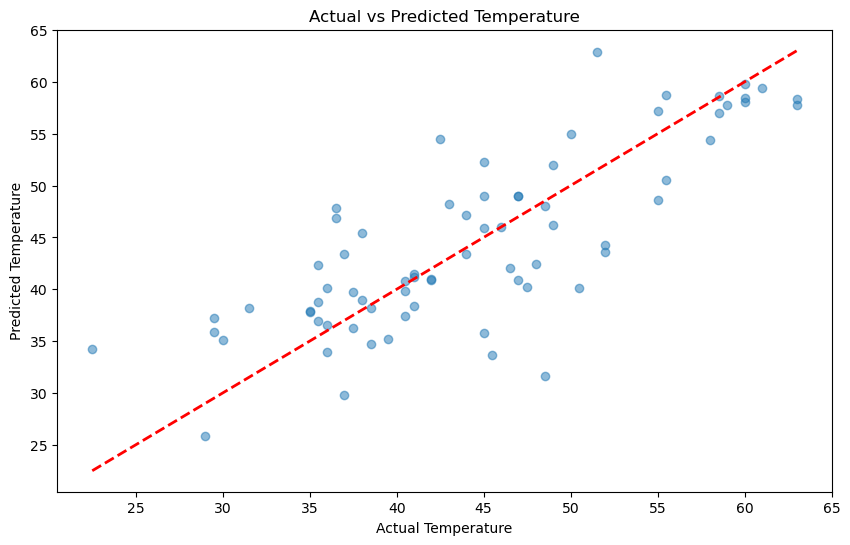

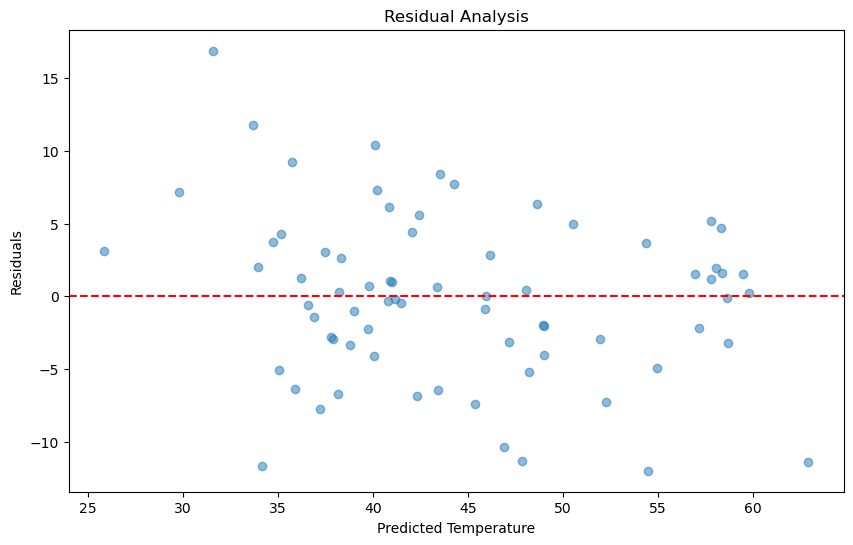

In [36]:
# Plot actual vs predicted
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], "r--", lw=2)
plt.xlabel("Actual Temperature")
plt.ylabel("Predicted Temperature")
plt.title("Actual vs Predicted Temperature")
plt.show()

# Plot residuals
residuals = y_test - y_pred
plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals, alpha=0.5)
plt.xlabel("Predicted Temperature")
plt.ylabel("Residuals")
plt.title("Residual Analysis")
plt.axhline(y=0, color="r", linestyle="--")
plt.show()

In [37]:
import joblib
from datetime import datetime

# Save model with timestamp
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
model_filename = f"weather_model_{timestamp}.joblib"
scaler_filename = f"scaler_{timestamp}.joblib"

# Save models and metadata
model_info = {
    "model": voting_regressor,
    "scaler": scaler,
    "features": features,
    "metrics": {"rmse": rmse, "r2": r2},
    "timestamp": timestamp,
}

joblib.dump(model_info, model_filename)
print(f"Model saved as {model_filename}")


def make_future_prediction(last_data, days_ahead=7):
    """
    Make predictions for the next n days
    """
    predictions = []
    current_data = last_data.copy()

    for _ in range(days_ahead):
        X_pred = current_data[features].iloc[[-1]]
        X_pred_scaled = scaler.transform(X_pred)
        pred = voting_regressor.predict(X_pred_scaled)[0]
        predictions.append(pred)

        new_row = current_data.iloc[-1:].copy()
        new_row["tavg"] = pred
        current_data = pd.concat([current_data, new_row])

    return predictions


# Example usage
# future_temps = make_future_prediction(df.iloc[-30:], days_ahead=7)
# print("Next 7 days temperature predictions:", future_temps)

Model saved as weather_model_20241224_181422.joblib
